# Angular power spectra
**[$\todo{Describe the new elements, like the window functions, galaxy distributions, biases, etc}$]()**

Now that we have taken a look at the theoretical matter power spectrum ([notebook #1; varying_P_k.ipynb](https://github.com/XanderHenrik/Masters-Project/blob/fadf527a729419f612ee98618f3fcc42747736e1/notebooks/varying_P_k.ipynb)), how do we observe this? How can we test our theoretical predictions of the matter power spectrum? To do so, we turn to the angular power spectra which we can relate to the actual observations of our Universe. The primordial perturbations in matter and radiation components of the Universe evolve through time to eventually form the Large Scale Structure (LSS) we know and live in today. The evolution of these perturbations is covered by the so-called *transfer function* which is time-independent. We can only observe the perturbations in the Cosmic Microwave Background (CMB), the state of the Universe at the time of last scattering. The CMB is a close to homogeneous background signal and the furthest we can actually look into the Universe. This research will take a special interest in the CMB lensing probe and integrating it into an already built-up analysis. In the built up analysis, 3 different cosmological large scale structure probes are combined to form an analysis of 3 auto-correlations and 3 cross-correlations. The probes in question are: Galaxy Clustering (GC) captured photometrically and spectroscopically and the Weak Lensing (or cosmic shear) probe. In this exercise, we look at the probes individually and at their auto and cross-correlations, more often referred to as angular power spectra. This is mainly due to the fact that we treat these observations in Fourier space and employ spherical harmonics to describe the observation projected on the (partial) spherical surface we observe.

The cosmic microwave background owes its name due to the fact that this is, to us, the first ever cosmic radiation we can observe. In some way this is the furthest we can look back into the universe. The cosmic microwave background is made up of all photons emitted at last scattering/recombination. These photons have approximately freely streamed throughout the complete expansion history and therefore redshifted into the microwace regime.
The CMB looks to be homogeneous and isotropic in 'larger' scales but contains anisotiropies in both photon temperature and polarzations. It is our job and goal to relate these anisotropies to the matter fluctuations in the primordial plasma.

To talk about:
- connection $C_{l} \propto P(k)$, through temperature fluctuations, conservation of superhorizon modes. $$C_{l}^{\alpha\beta} = \frac{2}{\pi} \int dk k^{2} P_{\alpha\beta}(k) \Delta_{l}^{\alpha}(k) \Delta_{l}^{\beta}(k)$$

with $$\Delta_{l}^{\alpha}(k, \chi) = f_{l}^{\alpha} W_{\alpha}(\chi)T_{\alpha}(k, \chi) j_{l}^{n_{\alpha}}(k, \chi)$$
- All possible probes of angular power spectra and the ones we are interested in.
- Auto-correlations and cross-correlations:
    - 3x2pt
    - 6x2pt
    - 10x2pt
- Quantification: $\Delta \chi^{2} \sim \left(C_{l}^{1} - C_{l}^{2}\right)^{T} Cov^{-1}(C_{l}^{1}) \left(C_{l}^{1} - C_{l}^{2}\right)$ of the correlations and the possible improvements on constraints

Literature to look at:
- **[6x2pt](https://arxiv.org/abs/2409.17377)**
- **[Neutrinos in $C_{l}$ and $P(k)$](https://arxiv.org/abs/1712.07109)**
- **[CCLX: Generalized tracers](https://github.com/LSSTDESC/CCLX/blob/master/GeneralizedTracers.ipynb)**
- **[CCLX: Angular power spectra](https://github.com/LSSTDESC/CCLX/blob/master/Angular%20cross-correlations.ipynb)**
- **[CCLX: Cells and Correlations](https://github.com/LSSTDESC/CCLX/blob/master/CellsCorrelations.ipynb)**
- **[Weinberg; chapters 2.6, 7 & 8]()**
- **[Modern Cosmology; chapters 11 & 13 on GC & WL]()**

In [66]:
import numpy as np
import pyccl as ccl
import pylab as plt
import math
from matplotlib import cm
import matplotlib.colors as mcolors
%matplotlib inline

## Cosmological model(s)

We will partially use the same format and setup as for the matter power spectrum. We start from the $\Lambda CDM$ model and vary the parameters within the base model to see the effect of the parameters on the angular power spectra. We take the same fiducial parameter values and priors.

In [67]:
"""
We initiate the Lambda-CDM model first using the same initial parameters:
- Omega_c: 0.27
- Omega_b: 0.045
- h: 0.67
- A_s: 2.1e-9
- n_s: 0.96

Then we will again look at the adittion of neutrino parameters and their effect on the angular power spectra.
We 
"""
lcdm_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# Compare this to the cosmology we get using the 'boltzmann_class' transfer function:
cosmo_class = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, 
                            transfer_function='boltzmann_class')
# print(cosmo, "\n", cosmo_class)

In [68]:
"""
Because the theoretical matter power spectrum is predicted for one specific redshift, this will be the first tweak we make.
For the angular power spectra, we include all the redshift in which we can observe the Universe, thus we are possibly interested 
in all redshifts for which: 0 < z < 1100

Next to the (possible) redshift dependencies, we must also introduce statistics that are characteristic to the probes, besides that,
we will also look at different underlying galaxy redshift distributions.
These new elements were not present in the prediction and calculation of the matter power spsectrum but become relevent now. 
"""

# For redshift dependent functions: we define the redshifts we look at, and define the redishift distributions:
z = np.linspace(0, 1.2, 1000)
scale_factor = (1. / (1 + z))[::-1] # The backwards indexing to guarantee that a is monotonically increasing, a CCL requirement

# Set up the ranges of k and the multipoles:
ks = np.logspace(-5, 2, 1000)
ells = np.arange(2, 1000)
# ells = np.linspace(2, 1000, 1000)


"""
To test the effect of the underlying galaxy redshift distribution on the angular power spectra, we define two different 
distributions and look at the effect they have on the tracers later.

The galaxy redshift distribution is determined by the function given in:
https://academic.oup.com/mnras/article/381/3/1018/1062897 - equation 5

and a twisted version of this, to generate the second galaxy redshift distrbution
"""
# dNdz's:
nz_1 = np.exp(-((z - 0.5) / 0.05)**2/2)
nz_2 = (46. * 100.31 * (26. - 25.)) * 1./(2.*(0.0417*26. - 0.744)) * (z / (0.0417*26. - 0.744))**2. * np.exp(-z/(0.0417*26. - 0.744))


# The statistics we :
lin_bias = 0.95/ccl.growth_factor(lcdm_cosmo,1./(1+z)) # linear bias for clustering of galaxies
mag_bias = np.ones_like(z) # Magnification bias
i_a = -0.004 * np.ones_like(z) # Intrinsic alignment amplitude

## Tracers
**[$\todo{Describe the tracers and how they do in fact tracer the underlying matter field}$]()**

**Dodelson Chapter 11 & 13; weak lensing**

We look at:
- **Galaxy clustering**: the NumberCountsTracer within CCL; which will include the matter overdensity contribution, multiplied by a linear, scale invariant bias redshift-space distortions and magnification.
    The galaxy clustering tracer observes the distribution of galaxies on large scales and therefore traces the distribution of visible matter. Although most of matter in the Universe comes in the form of cold dark matter (CDM), the baryonic(visible) matter closely follows the clustering of the CDM due to its dominant gravitational potential wells over the baryonic matter. This makes that baryonic matter closely follows the CDM in the formation of the large scale structure.
    Although galaxy clustering has a rather large redshift uncertainty, its power lies in the fact that it is sensitive to the growth and geometry of galaxy distributions over a larger period of time.

    Note: based on the specifics of the underlying galaxy redshift distributions, our galaxy clustering tracer describes photometric or spectroscopic galaxy clustering. For the photometric probe, we consider less accurate, broader and slightly overlapping redshift distributions to make up the tomographic redshift bins. For the spectroscopic tracer, we must define sharp and narrow tomographic bins, that only cover a part of the full redshift space we defined. For details, [notebook 2.5/3: identifiability_test.ipynb](https://github.com/XanderHenrik/Masters-Project/blob/main/notebooks/identifiability_test.ipynb)

- **Cosmic shear**: the WeakLensingTracer; which includes the cosmic shear term due to lensing and intrinsic alignment from the L-NLA model, with a scale invariant IA amplitude
    In the cosmic shear (or weak lensing) tracer, we observe distortions in the shape of distant galaxies caused by gravitational lensing. This trace considers a distant population of 'source galaxies' and a second population of all galaxies in between the observer (us) and these source galaxies, called the 'lensing or lens' galaxies. This population of lensing galaxies can be taken as the same population that is observed in the galaxy clustering probe.
    By looking at the distortions of the source galaxies, we can trace the underlying matter field that caused these distortions along the line of sight.

- **CMB lensing**: the CMBLensingTracer; from a single source redshift (usually set to $z = 1100$, zorresponding to the CMB)
    This probe can be compared to the last, since we consider a population of lesning galaxies again. This time however, we consider the source to the the cosmic microwave background and therefore, the lensing galaxies are all galaxies along the line of sight from today to z=1100 (the whole visible expansion history of the Universe)
    The CMB is also sensitive to neutrinos, which is the main argument for us to include it and lies at the base of this research. More on that later.

Next to these, we find other tracers that contribute to the observed CMB anisotropies but that we will probably not consider for this research:
- Integrated Saches Wolfe effect (ISW); the contribution of the gravitational field fluctuations along the line of sight.
- Thermal Sunyaev Zel'Dovich (tSZ) Compton-y fluctuations; (Compton) scattering of CMB radiation with intergalactic electrons along the line of sight
- Cosmic Infrared Background (CIB) intensity map; infrared radiation originating from stellar dust along the line of sight 

In [69]:
# Dictionary to group all tracers together:
tracers = {}

# Galaxy clustering Tracer:
gc = ccl.NumberCountsTracer(lcdm_cosmo, has_rsd=True, dndz=(z, nz_1), bias=(z, lin_bias), mag_bias=(z, mag_bias))
gc_nz_2 = ccl.NumberCountsTracer(lcdm_cosmo, has_rsd=True, dndz=(z, nz_2), bias=(z, lin_bias), mag_bias=(z, mag_bias))

# Cosmic shear:
wl = ccl.WeakLensingTracer(lcdm_cosmo, dndz=(z,nz_1), has_shear=True, ia_bias=(z, i_a))
wl_nz_2 = ccl.WeakLensingTracer(lcdm_cosmo, dndz=(z,nz_2), has_shear=True, ia_bias=(z, i_a))

# CMB Lensing:
cmbl = ccl.CMBLensingTracer(lcdm_cosmo, z_source=1100.)
 

### A small CCLX exercise

**Looking at the effect of scale cuts** 

Since the gravitational collapse is a non-linear phenomenon, structure formation on the smallest scales contains a lot of non-linear characteristics and behavior. These scales are unpredictable and not determined to great precision, leading to the often-made choice to impose a scale-cut in the matter power spectrum or the angular power spectra on the smallest scales.

To lookat this, we consider the non-linear matter power spectrum and definte a case with and without a scale cut.
Based on the galaxy clustering tracer we defined above, we define the angular power spectrum for both galaxy redshift distributions. Then we apply the scale cuts to them and plot the results. 

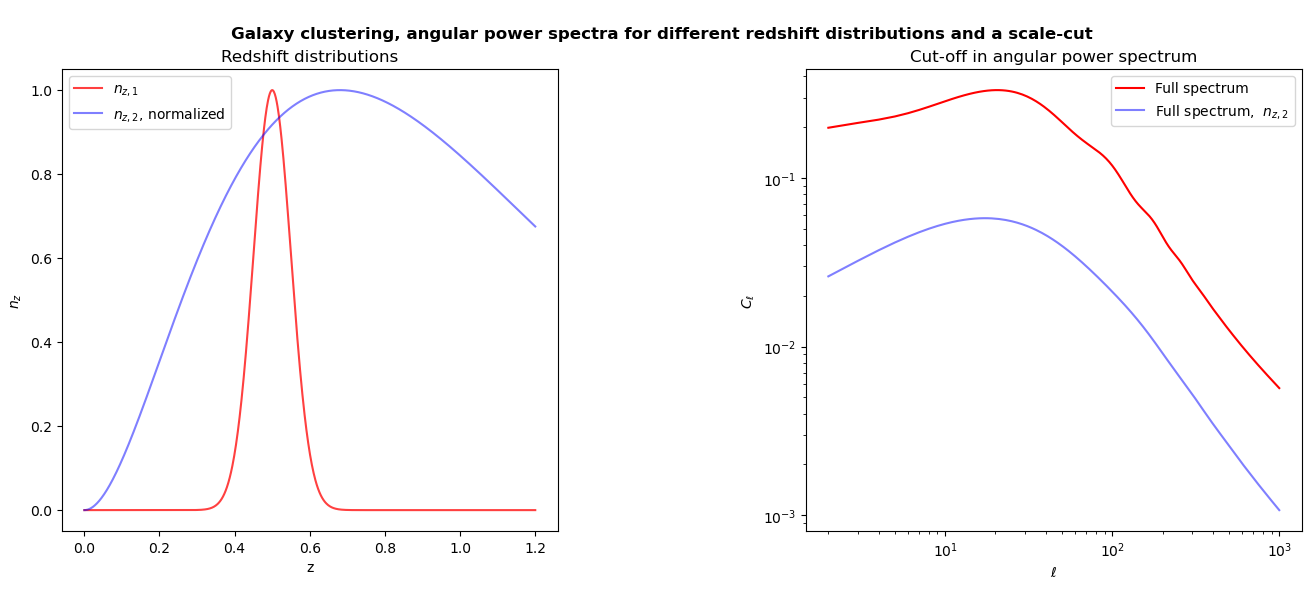

In [70]:
# Start with the non-linear matter power spectrum: 
lpk_array = np.log(np.array([ccl.nonlin_matter_power(lcdm_cosmo, ks, a) for a in scale_factor]))

# Let us define a cut-off scale and implement the cut-off in the matter power spectrum:
k_cut = 0.4 # This corresponds to a scale of ~10 Mpc
lpk_array -= (ks/k_cut)**2

# By default, in ccl uses the non-linear matter power spectrum in the calculation for the angular power spectra; however, 
# a more general approach is to use the object Pk2D, which incorporates both the k and a dependence of the matter power spectrum.
pk_cut = ccl.Pk2D(a_arr=scale_factor, lk_arr=np.log(ks), pk_arr=lpk_array, is_logp=True)

# Now we define the angular power spectra for both the full matter power spectrum and the angular power spectra with cut-off:
# We do this for galaxy clustering, excluding rsd & magnification bias,
cl_gc_no_cut = ccl.angular_cl(lcdm_cosmo, gc, gc, ells)
# cl_gc_with_cut = ccl.angular_cl(lcdm_cosmo, gc, gc, ells, p_of_k_a=pk_cut, l_limber='auto')

# # Compare with the other redshift distribution:
cl_gc_no_cut_nz_2 = ccl.angular_cl(lcdm_cosmo, gc_nz_2, gc_nz_2, ells)
# cl_gc_with_cut_nz_2 = ccl.angular_cl(lcdm_cosmo, gc_nz_2, gc_nz_2, ells, p_of_k_a=pk_cut, l_limber='auto')

# Initiate the plot:
fig, axes = plt.subplots(figsize=[16, 6], nrows=1, ncols=2)
plt.suptitle("\nGalaxy clustering, angular power spectra for different redshift distributions and a scale-cut\n", weight='bold')
# plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

# Plot the redshift distributions:
axes[0].plot(z, nz_1, 'r-', label=r'$n_{z, 1}$', alpha=0.75)
axes[0].plot(z, nz_2/np.max(nz_2), 'b-', label=r'$n_{z, 2}$, normalized', alpha=0.5)

# Plot-readability:
axes[0].set_title("Redshift distributions")
axes[0].legend()
axes[0].set_xlabel('z')
axes[0].set_ylabel(r'$n_{z}$')

# # Plot the two angular poiwer spectra:
axes[1].loglog(ells, 1e4*cl_gc_no_cut, 'r-', label='Full spectrum')
# axes[1].loglog(ells, 1e4*cl_gc_with_cut, 'k--', label='Spectrum with cut-off')
axes[1].loglog(ells, 1e4*cl_gc_no_cut_nz_2, 'b-', label=r'Full spectrum,  $n_{z, 2}$', alpha=0.5)
# axes[1].loglog(ells, 1e4*cl_gc_with_cut_nz_2, 'k--', label=r'$n_{z, 2}$ with cut-off', alpha=0.5)

# Plot-readability:
axes[1].set_title("Cut-off in angular power spectrum")
axes[1].legend()
axes[1].set_xlabel(r'$\ell$')
axes[1].set_ylabel(r'$C_{\ell}$')
plt.show()


## Correlation functions:
Now we take a closer look at the (cross-) correlations corresponding to the angular power spectra of auto/cross correlated tracers. The cross correlations are the real-space variant of the angular power spectra nand are thus plotted for the angle at which  we observe them in the sky. 


### Auto correlations:
Look at the angular power spectra of auto correlatied tracers;

**NOTE: check the actual definitions in [CCLX; CellsCorrelations](https://github.com/LSSTDESC/CCLX/blob/master/CellsCorrelations.ipynb)**

<>:42: SyntaxWarning: invalid escape sequence '\e'
<>:42: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_8263/2384380313.py:42: SyntaxWarning: invalid escape sequence '\e'
  """


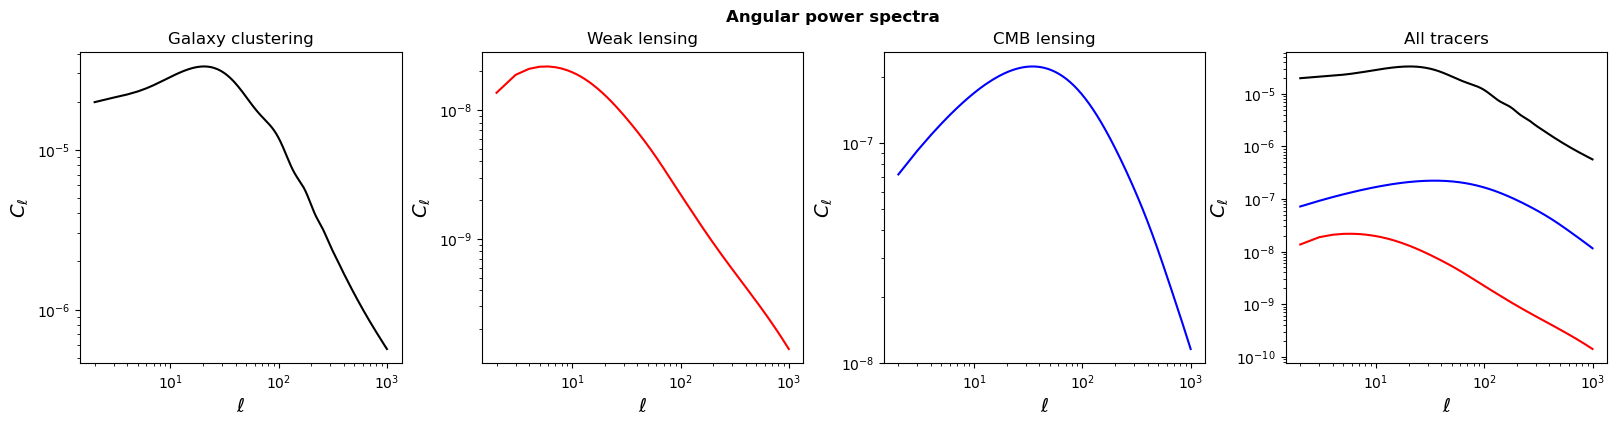

'\n# Initiate the plot:\nplt.figure()\nplt.title(r"\nAngular power spectra\n", weight=\'bold\', fontsize=16)\n\n# PLot angular power spectra:\nplt.loglog(ells, cls_gc, \'k-\', label=\'Galaxy clustering\')\nplt.loglog(ells, cls_wl, \'r-\', label=\'Weak lensing\')\nplt.loglog(ells, cls_cmb, \'b-\', label=\'CMB lensing\')\n\n# Readability of the plot:\nplt.legend(fontsize=12)\nplt.xlabel(r\'$\\ell$\', fontsize=14)\nplt.ylabel(r\'$C_{\\ell}$\', fontsize=14)\nplt.ylim(1e-11, 5e-5)\nplt.show()\n'

In [73]:
# Define angular power spectra, using the definitions of the tracers above:
ells = np.arange(2, 1000)

cls_gc = ccl.angular_cl(lcdm_cosmo, gc, gc, ells)
cls_wl = ccl.angular_cl(lcdm_cosmo, wl, wl, ells)
cls_cmbl = ccl.angular_cl(lcdm_cosmo, cmbl, cmbl, ells)

# Set up a multiplot:
fig, axes = plt.subplots(figsize=(16, 4), ncols=4, nrows=1)
plt.suptitle("Angular power spectra", weight='bold')
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

# GC:
axes[0].set_title("Galaxy clustering")
axes[0].loglog(ells, cls_gc, color='black')
axes[0].set_xlabel(r"$\ell$", fontsize=14)
axes[0].set_ylabel(r"$C_{\ell}$", fontsize=14)

# WL:
axes[1].set_title("Weak lensing")
axes[1].loglog(ells, cls_wl, color='red')
axes[1].set_xlabel(r"$\ell$", fontsize=14)
axes[1].set_ylabel(r"$C_{\ell}$", fontsize=14)

# CMB lensing:
axes[2].set_title("CMB lensing")
axes[2].loglog(ells, cls_cmbl, color='blue')
axes[2].set_xlabel(r"$\ell$", fontsize=14)
axes[2].set_ylabel(r"$C_{\ell}$", fontsize=14)

# Combined:
axes[3].set_title("All tracers")
axes[3].loglog(ells, cls_gc, color='black', label="Galaxy clustering")
axes[3].loglog(ells, cls_wl, color='red', label="Weak lensing")
axes[3].loglog(ells, cls_cmbl, color='blue', label="CMB lensing")
axes[3].set_xlabel(r"$\ell$", fontsize=14)
axes[3].set_ylabel(r"$C_{\ell}$", fontsize=14)

plt.show()

"""
# Initiate the plot:
plt.figure()
plt.title(r"\nAngular power spectra\n", weight='bold', fontsize=16)

# PLot angular power spectra:
plt.loglog(ells, cls_gc, 'k-', label='Galaxy clustering')
plt.loglog(ells, cls_wl, 'r-', label='Weak lensing')
plt.loglog(ells, cls_cmb, 'b-', label='CMB lensing')

# Readability of the plot:
plt.legend(fontsize=12)
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel(r'$C_{\ell}$', fontsize=14)
plt.ylim(1e-11, 5e-5)
plt.show()
"""

### Cross-correlatied tracers:

Look at the angular power spectra of cross correlated tracers, using the tracers we defined above.
Note that the cross-correlation of the galaxy clustering and weak lensing tracers has to be done in a specific manner. Weak lensing is built up by a galaxy redshift distribution (the source distribution) in the far field that is gravitationally lensed by a galaxy redshift distribution in between this source distribution and the observer (the lens distribution). To actually det up the galaxy-galaxy lensing cross correlation, we would have to define the galaxy redshift distribution in multiple tomographic redshift bins and correlate them according to the geometric ordering of the weak lensing probe design. This is something we will set up in the next [notebook](https://github.com/XanderHenrik/Masters-Project/blob/main/notebooks/identifiability_test.ipynb) 

In this notebook we rather test the shape of the angular power spectra and the effects of the (neutrino) parameters on these power spectra. Therefore we will keep the setup simple and set up all tracers and angular power spectra in one tomographic bin, defined by the redshift space we look at.


<pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0xb115c5c2eaee50c0  0xf6cd4f3af922b7b1    0       0    
	 1  0xb115c5c2eaee50c0  0x947983d189b991ef    0       2    
	 2  0x893bd303431711bb         None           1       -1   


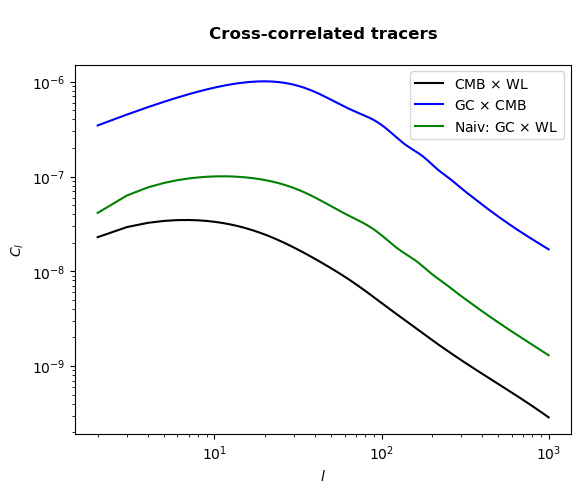

In [74]:
# Define the angular power spectra of cross correlated tracers:
cls_cmb_wl = ccl.angular_cl(lcdm_cosmo, wl, cmbl, ells)
cls_cmb_gc = ccl.angular_cl(lcdm_cosmo, gc, cmbl, ells)
naiv_cls_gc_wl = ccl.angular_cl(lcdm_cosmo, gc, wl, ells)
print(gc)
# cls_gc_wl = ccl.angular_cl(lcdm_cosmo, gc[:-1], wl[1:], ells)

# Initiate the plot:
plt.figure()
plt.title("\nCross-correlated tracers\n", weight='bold')

# Plotting:
plt.loglog(ells, cls_cmb_wl, 'k-', label=r'CMB $\times$ WL')
plt.loglog(ells, cls_cmb_gc, 'b-', label=r'GC $\times$ CMB')
plt.loglog(ells, naiv_cls_gc_wl, 'g-', label=r'Naiv: GC $\times$ WL')
# plt.loglog(ells, cls_gc_wl, 'k-', label=r'GC $\times$ WL')

# Uprgade the plot:
plt.legend()
plt.xlabel('$l$')
plt.ylabel('$C_l$')
plt.show()

# Varying parameters in $C_{\ell}$ spectra

Now that we have set up the angular power spectra for the probes we are interested in, we can start with looking at the effect of the cosmological parameters on the angular power spectra.
Like mentioned above, we will do this in a similar fashion as we did for the matter power spectrum and also consider the asme priors and fiducial cosmologies ([notebook #1; varying_P_k.ipynb](https://github.com/XanderHenrik/Masters-Project/blob/fadf527a729419f612ee98618f3fcc42747736e1/notebooks/varying_P_k.ipynb)).


In [77]:
# Let us define the priors we found and defined above:
om_c_prior = np.geomspace(0.1, 0.9, 10)
om_b_prior = np.geomspace(0.03, 0.07, 10)
h_prior = np.geomspace(0.55, 0.91, 10)
a_s_prior = np.geomspace(0.5e-9, 5.0e-9, 10)
n_s_prior = np.geomspace(0.87, 1.07, 10)
n_eff_prior = np.geomspace(0.046, 6.046, 10)
de_prior = np.geomspace(-3, -0.33, 10) # We might or might not make use of this

# Combine into one list of all priors, for plotting purposes:
priors = [om_c_prior, om_b_prior, h_prior, a_s_prior, n_s_prior, n_eff_prior]

"""
Now we will define a function that can loop and plot the angular power spectra for different values within the given prior range

Take Lambda-CDM as a base level and vary one parameter at the time, keeping the rest set to their default Lambda-CDM values
This way we define the angular power spectra with variations in each parameter separately.

We must build the angular power spectra up from the cosmology object on in each  iteration, since the cosmology cannot be mutated easily
after definition. From the cosmology, we determine the tracer and then the angular power spectra.
"""
def varying_C_l(Cl, parameter, prior, neutrinos=None, mass_split=None):
    """
    This function varies the given parameter within the range of the prior given. For each values we build the angular power spectrum of
    auto correlated tracers, this might be changed to cross-correlations if insightful.
    This function assumes that the statistics have been set in a 

    CL: str. to specify the trace we will build the spectra from. GC, WL or CMBL
    parameter: str. given the parameter name of the cosmological parameter we want to vary
    prior: np.array. the range of values within which the parameter is varied
    neutrinos: list. containing the list of 3 neutrino masses in eV, default: None, no neutrinos incorporated
    mass_split: str. Specifying the mass ordering of neutrinos. Default, None.
        either use: "normal", "inverted" or "single"

    return:
    list of angular power spectra of similar length as the prior 
    """
    # reference cosmology:
    lcdm_pars = {
        "Omega_c": 0.27, 
        "Omega_b": 0.045, 
        "h": 0.67, 
        "A_s": 2.1e-9, 
        "n_s": 0.96, 
        "Neff": 3.044,
    }
    
    # Regulate neutrino inputs:
    if neutrinos is not None:
        lcdm_pars[r"m_nu"] = neutrinos
    if mass_split is not None:
        lcdm_pars[r"mass_split"] = mass_split

    varied_C_l = []

    # For the cosmology independent statistics:
    z = np.linspace(0, 1.2, 1000)
    mag_bias = np.ones_like(z) # Magnification bias
    i_a = -0.004 * np.ones_like(z) # Intrinsic alignment amplitude
    dndz = np.exp(-((z - 0.5) / 0.05)**2/2)
    ell = np.arange(2, 1000)

    for i in range(len(prior)):

        # Set the cosmology and the cosmology dependent statistics:
        lcdm_pars[parameter] = prior[i]
        cosmology_i = ccl.cosmology.Cosmology(**lcdm_pars)
        lin_bias = 0.95/ccl.growth_factor(cosmology_i, 1./(1+z)) # linear bias for clustering of galaxies

        # Set up the tracer:
        if Cl.lower() == "gc":
            tracer_i = ccl.NumberCountsTracer(cosmology_i, has_rsd=True, dndz=(z, dndz), bias=(z, lin_bias), mag_bias=(z, mag_bias))
        elif Cl.lower() == "wl":
            tracer_i = ccl.WeakLensingTracer(cosmology_i, dndz=(z,dndz), has_shear=True, ia_bias=(z, i_a))
        elif Cl.lower() == "cmbl":
            tracer_i = ccl.CMBLensingTracer(cosmology_i, z_source=1100.)
        
        # Now that the tracer is defined, calculate the angular power spectrum and save it to be returned later:
        C_l_i = ccl.angular_cl(cosmology_i, tracer_i, tracer_i, ell)
        varied_C_l.append(C_l_i)

        # Reset the cosmology to Lambda-CDM:
        lcdm_pars = {
            "Omega_c": 0.27, 
            "Omega_b": 0.045,
            "h": 0.67, 
            "A_s": 2.1e-9, 
            "n_s": 0.96, 
            "Neff": 3.044,
        }

    return varied_C_l


## Variations in angular auto spectra
Now we use the functino defined above to plot the different angular power spectra for the varations in the parameters.
We will star with galaxy clustering, followed by weak lensing and at last, CMB lensing. We will later also look at the variations in the neutrino masses and their mass ordering.

In [78]:
# First we look at the angular power spectrum of galaxy clustering:
var_cdm_gc = varying_C_l("GC", r"Omega_c", om_c_prior)
var_bar_gc = varying_C_l("GC", r"Omega_b", om_b_prior)
var_hubble_gc = varying_C_l("GC", r"h", h_prior)
var_as_gc = varying_C_l("GC", r"A_s", a_s_prior)
var_ns_gc = varying_C_l("GC", r"n_s", n_s_prior)
var_neff_gc = varying_C_l("GC", r"Neff", n_eff_prior)

varied_C_ls_gc = [var_cdm_gc, var_bar_gc, var_hubble_gc, var_as_gc, var_ns_gc, var_neff_gc]
# Some variables we need:
lcdm_pars = {
            "Omega_c": 0.27, 
            "Omega_b": 0.045,
            "h": 0.67, 
            "A_s": 2.1e-9, 
            "n_s": 0.96, 
            "Neff": 3.044,
        }

/tmp/ipykernel_8263/2385613187.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')


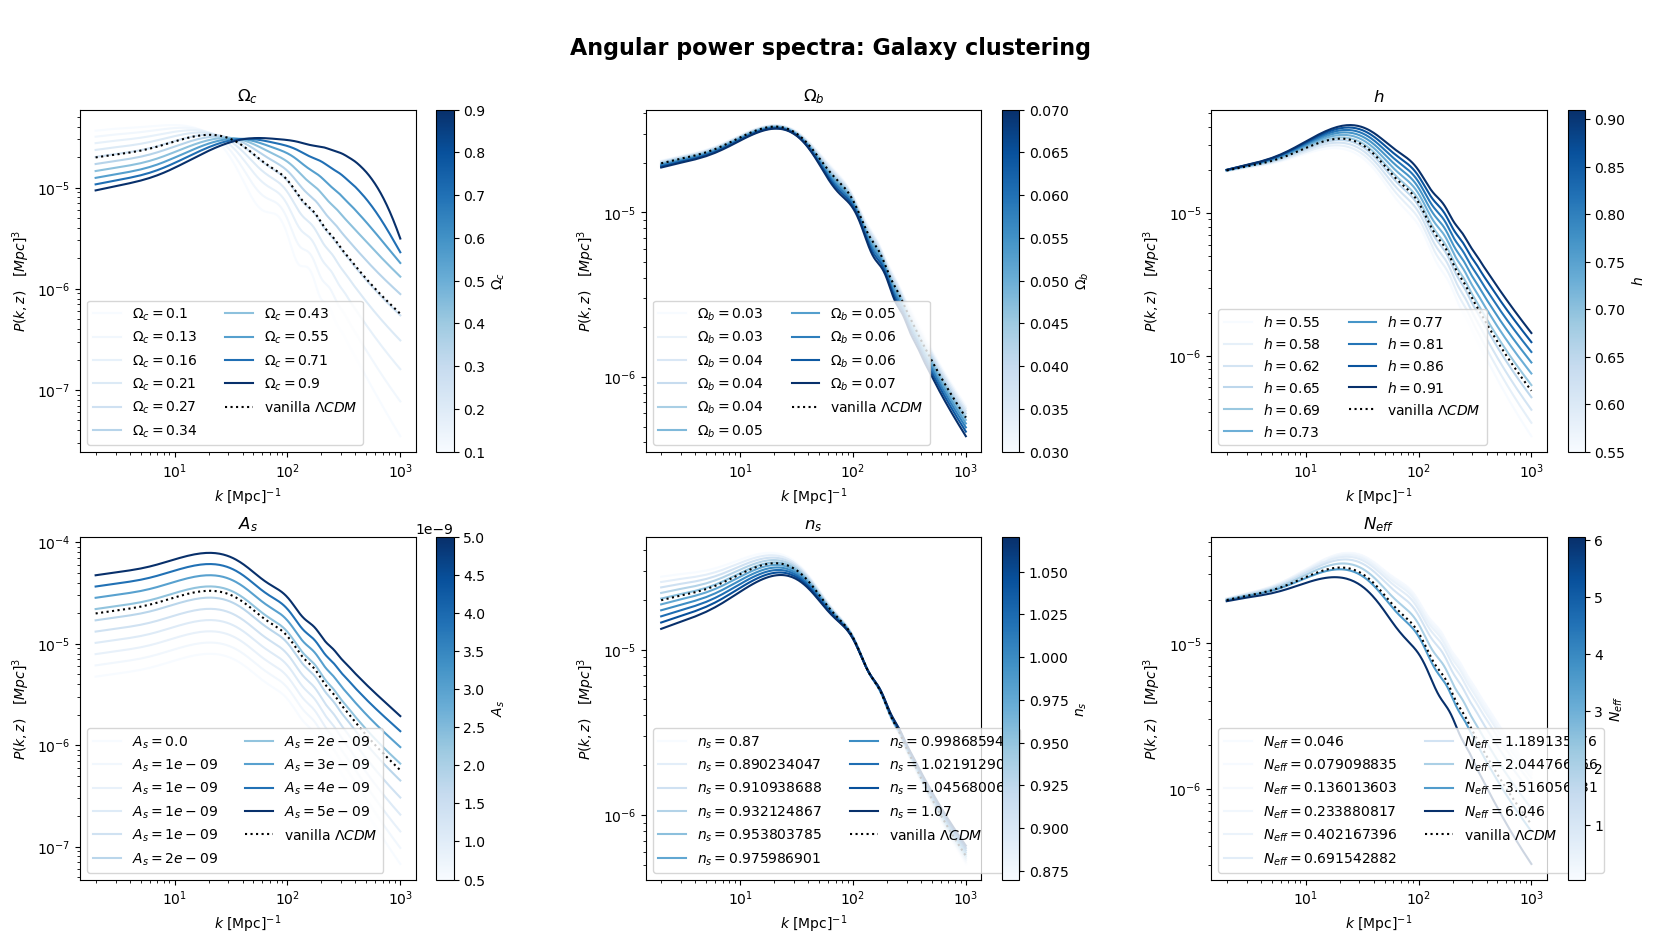

In [79]:
keys = [r"$\Omega_c$", r"$\Omega_b$", r"$h$", r"$A_s$", r"$n_s$", r"$N_{eff}$"]
ells = np.arange(2, 1000)

# Now we plot the results:
fig, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=3)
fig.suptitle("\nAngular power spectra: Galaxy clustering", weight="bold", fontsize=16)
plt.subplots_adjust(hspace=0.25, wspace=0.35)

# Add colormap and plot all graphs in color red, disticted by the saturation of the color
cmap = cm.get_cmap('Blues')

# Now we want to write a loop that plots all the varations to the linear power spectrum of a single parameter into a subplot.
for j in range(0, 3):
    # Define the range of the colors in the plot
    norm_row1 = mcolors.Normalize(vmin=min(priors[j]), vmax=max(priors[j]))
    norm_row2 = mcolors.Normalize(vmin=min(priors[j + 3]), vmax=max(priors[j + 3]))
    for i in range(len(priors[0])):

        # Make a ScalarMappable for the colorbar
        color_row1 = cmap(norm_row1(priors[j][i]))
        sm_row1 = cm.ScalarMappable(cmap=cmap, norm=norm_row1)
        sm_row1.set_array([])  # To avoid errors
        
        # Split the subplots per row, the first row for j = 0, 1, 2
        # First row:
        axes[0, j].loglog(ells, varied_C_ls_gc[j][i], color=color_row1, label=keys[j] + r"$= {}$".format(np.round(priors[j][i], 2)))
        
        # Add titles, labels:
        axes[0, j].set_title(keys[j], weight="bold")
        axes[0, j].set_xlabel(r'$k$ [Mpc]$^{-1}$')
        axes[0, j].set_ylabel(r'$P(k, z)\quad [Mpc]^{3}$')
        
        # Second row:
        # Set up the colors:
        color_row2 = cmap(norm_row2(priors[j + 3][i]))
        sm_row2 = cm.ScalarMappable(cmap=cmap, norm=norm_row2)
        sm_row2.set_array([])  # To avoid errors

        axes[1, j].loglog(ells, varied_C_ls_gc[j + 3][i], color=color_row2, label=keys[j + 3] + r"$= {}$".format(np.round(priors[j + 3][i], 9)))
        
        # Add titles, labels:
        axes[1, j].set_title(keys[j + 3], weight="bold")
        axes[1, j].set_xlabel(r'$k$ [Mpc]$^{-1}$')
        axes[1, j].set_ylabel(r'$P(k, z) \quad [Mpc]^{3}$')
    
    # Add colorbar to the subplots in row 1 & 2 respectively:
    cbar_row1 = fig.colorbar(sm_row1, ax=axes[0, j], label=keys[j])
    cbar_row2 = fig.colorbar(sm_row2, ax=axes[1, j], label=keys[j + 3])

    # Plot the reference value for "vanilla-LCDM" and the legend himself:
    axes[0, j].loglog(ells, cls_gc, ":", color='k', label=r"vanilla $\Lambda CDM$")
    axes[0, j].legend(loc='lower left', ncols=2)
    axes[1, j].loglog(ells, cls_gc, ":", color='k', label=r"vanilla $\Lambda CDM$")
    axes[1, j].legend(loc='lower left', ncols=2)

plt.show()

In [80]:
# First we look at the angular power spectrum of galaxy clustering:
var_cdm_wl = varying_C_l("WL", r"Omega_c", om_c_prior)
var_bar_wl = varying_C_l("WL", r"Omega_b", om_b_prior)
var_hubble_wl = varying_C_l("WL", r"h", h_prior)
var_as_wl = varying_C_l("WL", r"A_s", a_s_prior)
var_ns_wl = varying_C_l("WL", r"n_s", n_s_prior)
var_neff_wl = varying_C_l("WL", r"Neff", n_eff_prior)

varied_C_ls_wl = [var_cdm_wl, var_bar_wl, var_hubble_wl, var_as_wl, var_ns_wl, var_neff_wl]

/tmp/ipykernel_8263/4210241254.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')


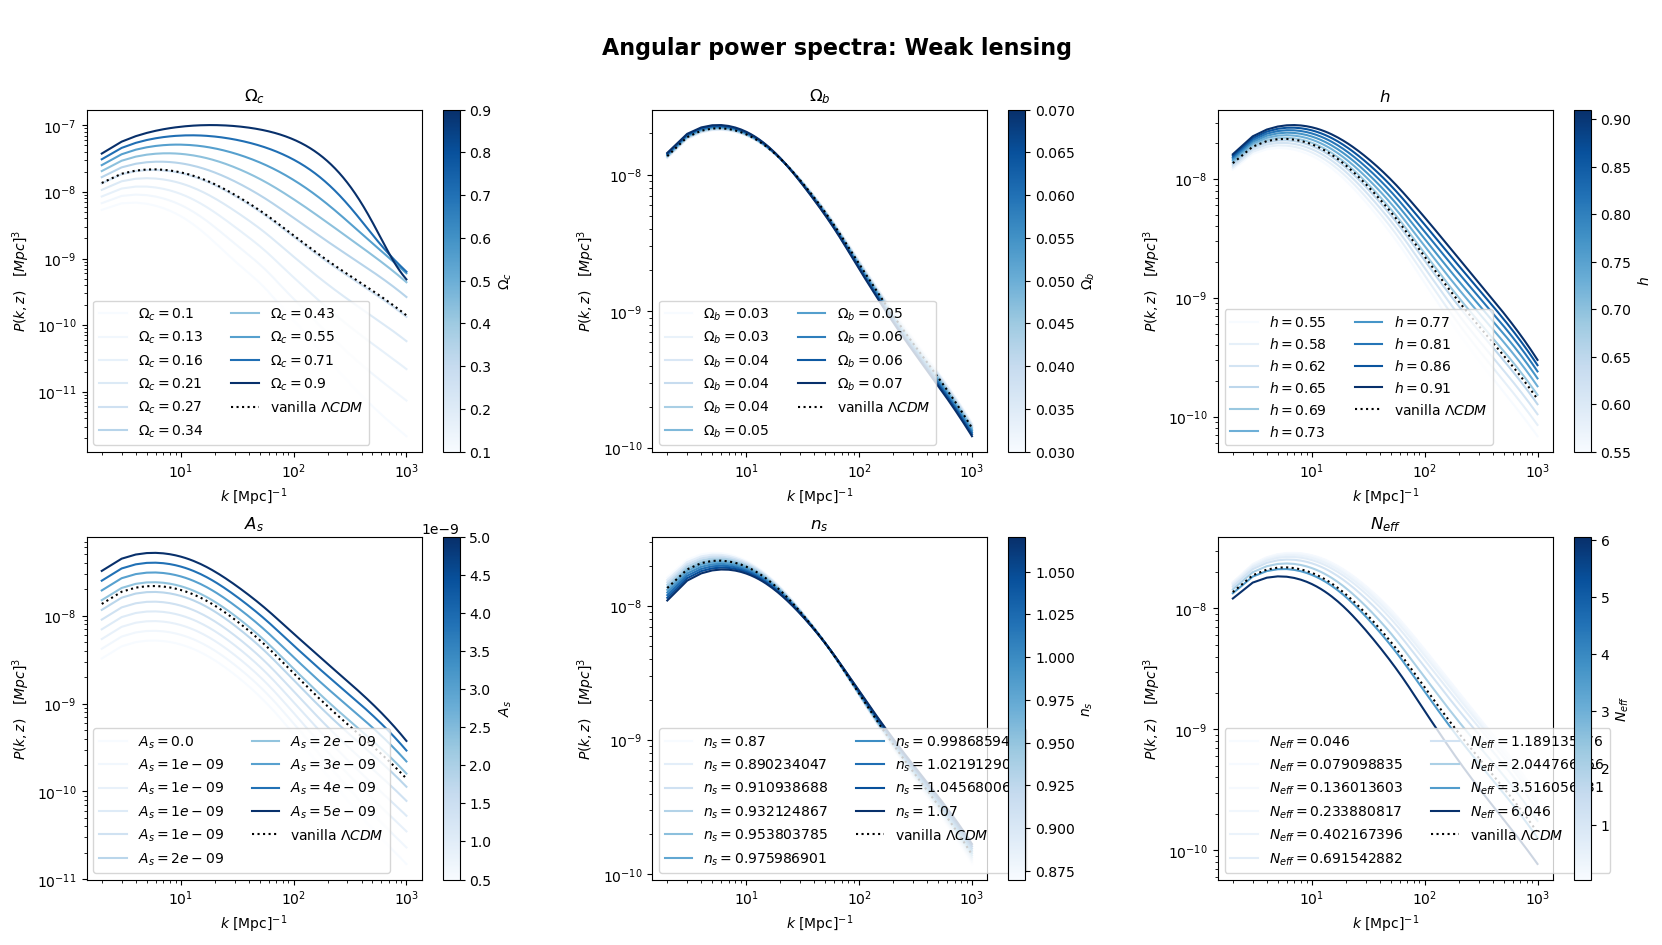

In [81]:
# Now we plot the results:
fig, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=3)
fig.suptitle("\nAngular power spectra: Weak lensing", weight="bold", fontsize=16)
plt.subplots_adjust(hspace=0.25, wspace=0.35)

# Add colormap and plot all graphs in color red, disticted by the saturation of the color
cmap = cm.get_cmap('Blues')

# Now we want to write a loop that plots all the varations to the linear power spectrum of a single parameter into a subplot.
for j in range(0, 3):
    # Define the range of the colors in the plot
    norm_row1 = mcolors.Normalize(vmin=min(priors[j]), vmax=max(priors[j]))
    norm_row2 = mcolors.Normalize(vmin=min(priors[j + 3]), vmax=max(priors[j + 3]))
    for i in range(len(priors[0])):

        # Make a ScalarMappable for the colorbar
        color_row1 = cmap(norm_row1(priors[j][i]))
        sm_row1 = cm.ScalarMappable(cmap=cmap, norm=norm_row1)
        sm_row1.set_array([])  # To avoid errors
        
        # Split the subplots per row, the first row for j = 0, 1, 2
        # First row:
        axes[0, j].loglog(ells, varied_C_ls_wl[j][i], color=color_row1, label=keys[j] + r"$= {}$".format(np.round(priors[j][i], 2)))
        
        # Add titles, labels:
        axes[0, j].set_title(keys[j], weight="bold")
        axes[0, j].set_xlabel(r'$k$ [Mpc]$^{-1}$')
        axes[0, j].set_ylabel(r'$P(k, z)\quad [Mpc]^{3}$')
        
        # Second row:
        # Set up the colors:
        color_row2 = cmap(norm_row2(priors[j + 3][i]))
        sm_row2 = cm.ScalarMappable(cmap=cmap, norm=norm_row2)
        sm_row2.set_array([])  # To avoid errors

        axes[1, j].loglog(ells, varied_C_ls_wl[j + 3][i], color=color_row2, label=keys[j + 3] + r"$= {}$".format(np.round(priors[j + 3][i], 9)))
        
        # Add titles, labels:
        axes[1, j].set_title(keys[j + 3], weight="bold")
        axes[1, j].set_xlabel(r'$k$ [Mpc]$^{-1}$')
        axes[1, j].set_ylabel(r'$P(k, z) \quad [Mpc]^{3}$')
    
    # Add colorbar to the subplots in row 1 & 2 respectively:
    cbar_row1 = fig.colorbar(sm_row1, ax=axes[0, j], label=keys[j])
    cbar_row2 = fig.colorbar(sm_row2, ax=axes[1, j], label=keys[j + 3])

    # Plot the reference value for "vanilla-LCDM" and the legend himself:
    axes[0, j].loglog(ells, cls_wl, ":", color='k', label=r"vanilla $\Lambda CDM$")
    axes[0, j].legend(loc='lower left', ncols=2)
    axes[1, j].loglog(ells, cls_wl, ":", color='k', label=r"vanilla $\Lambda CDM$")
    axes[1, j].legend(loc='lower left', ncols=2)

plt.show()

In [85]:
# First we look at the angular power spectrum of galaxy clustering:
var_cdm_cmbl = varying_C_l("CMBL", r"Omega_c", om_c_prior)
var_bar_cmbl = varying_C_l("CMBL", r"Omega_b", om_b_prior)
var_hubble_cmbl = varying_C_l("CMBL", r"h", h_prior)
var_as_cmbl = varying_C_l("CMBL", r"A_s", a_s_prior)
var_ns_cmbl = varying_C_l("CMBL", r"n_s", n_s_prior)
var_neff_cmbl = varying_C_l("CMBL", r"Neff", n_eff_prior)

varied_C_ls_cmbl = [var_cdm_cmbl, var_bar_cmbl, var_hubble_cmbl, var_as_cmbl, var_ns_cmbl, var_neff_cmbl]

/tmp/ipykernel_8263/3898086159.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')


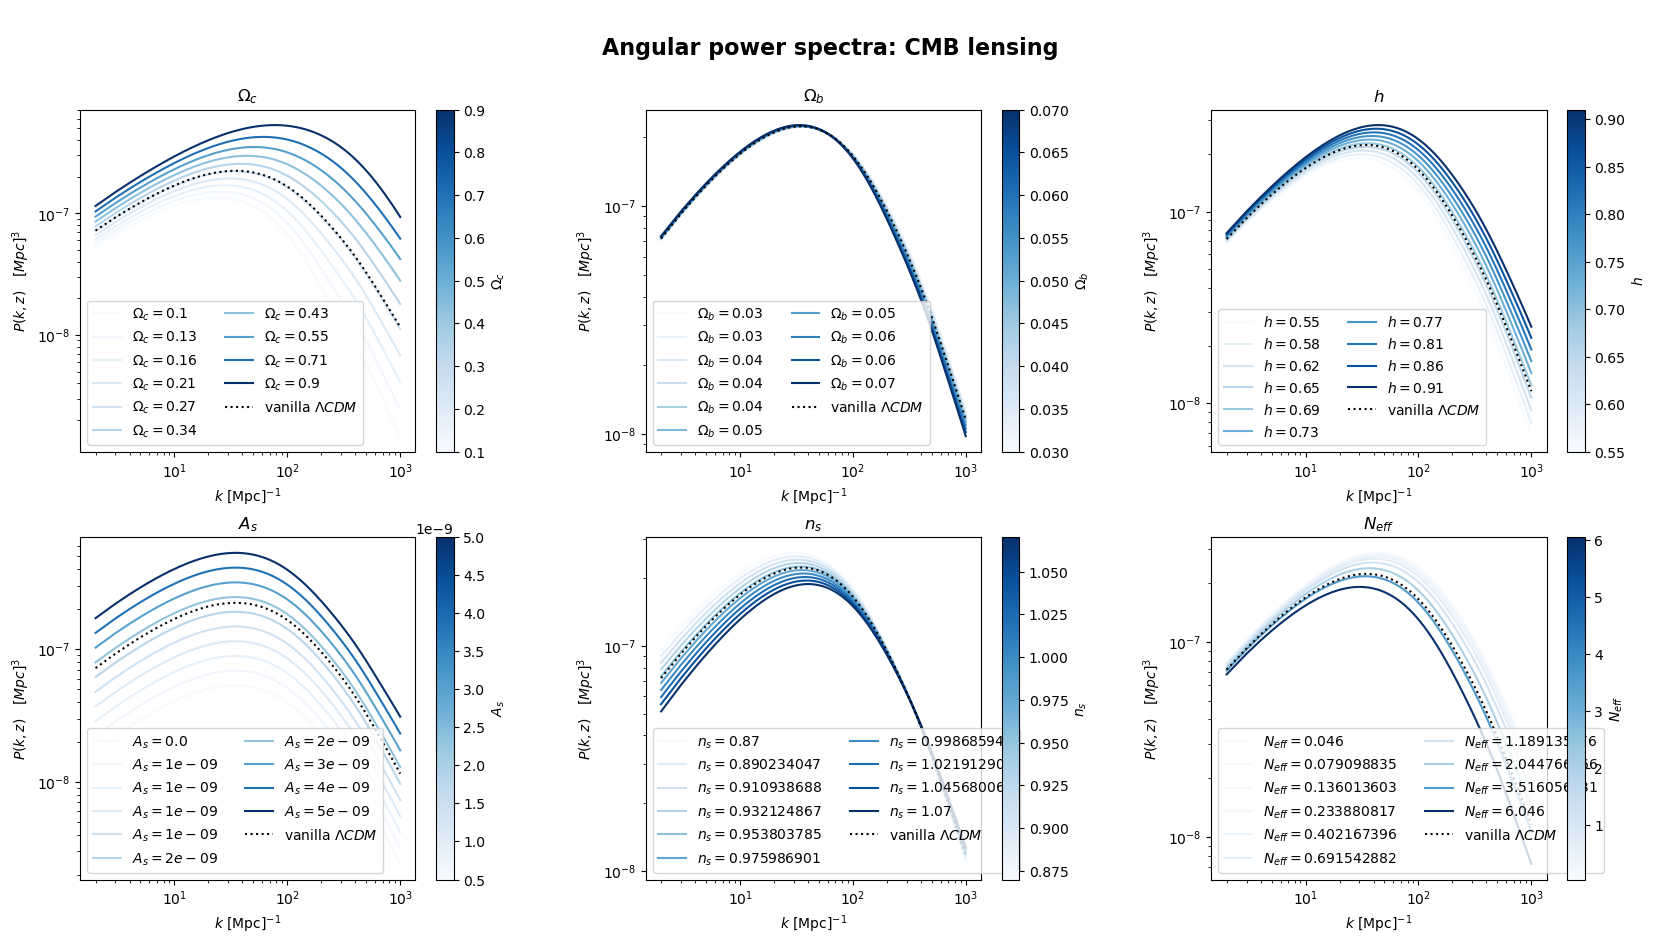

In [86]:
keys = [r"$\Omega_c$", r"$\Omega_b$", r"$h$", r"$A_s$", r"$n_s$", r"$N_{eff}$"]
ells = np.arange(2, 1000)

# Now we plot the results:
fig, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=3)
fig.suptitle("\nAngular power spectra: CMB lensing", weight="bold", fontsize=16)
plt.subplots_adjust(hspace=0.25, wspace=0.35)

# Add colormap and plot all graphs in color red, disticted by the saturation of the color
cmap = cm.get_cmap('Blues')

# Now we want to write a loop that plots all the varations to the linear power spectrum of a single parameter into a subplot.
for j in range(0, 3):
    # Define the range of the colors in the plot
    norm_row1 = mcolors.Normalize(vmin=min(priors[j]), vmax=max(priors[j]))
    norm_row2 = mcolors.Normalize(vmin=min(priors[j + 3]), vmax=max(priors[j + 3]))
    for i in range(len(priors[0])):

        # Make a ScalarMappable for the colorbar
        color_row1 = cmap(norm_row1(priors[j][i]))
        sm_row1 = cm.ScalarMappable(cmap=cmap, norm=norm_row1)
        sm_row1.set_array([])  # To avoid errors
        
        # Split the subplots per row, the first row for j = 0, 1, 2
        # First row:
        axes[0, j].loglog(ells, varied_C_ls_cmbl[j][i], color=color_row1, label=keys[j] + r"$= {}$".format(np.round(priors[j][i], 2)))
        
        # Add titles, labels:
        axes[0, j].set_title(keys[j], weight="bold")
        axes[0, j].set_xlabel(r'$k$ [Mpc]$^{-1}$')
        axes[0, j].set_ylabel(r'$P(k, z)\quad [Mpc]^{3}$')
        
        # Second row:
        # Set up the colors:
        color_row2 = cmap(norm_row2(priors[j + 3][i]))
        sm_row2 = cm.ScalarMappable(cmap=cmap, norm=norm_row2)
        sm_row2.set_array([])  # To avoid errors

        axes[1, j].loglog(ells, varied_C_ls_cmbl[j + 3][i], color=color_row2, label=keys[j + 3] + r"$= {}$".format(np.round(priors[j + 3][i], 9)))
        
        # Add titles, labels:
        axes[1, j].set_title(keys[j + 3], weight="bold")
        axes[1, j].set_xlabel(r'$k$ [Mpc]$^{-1}$')
        axes[1, j].set_ylabel(r'$P(k, z) \quad [Mpc]^{3}$')
    
    # Add colorbar to the subplots in row 1 & 2 respectively:
    cbar_row1 = fig.colorbar(sm_row1, ax=axes[0, j], label=keys[j])
    cbar_row2 = fig.colorbar(sm_row2, ax=axes[1, j], label=keys[j + 3])

    # Plot the reference value for "vanilla-LCDM" and the legend himself:
    axes[0, j].loglog(ells, cls_cmbl, ":", color='k', label=r"vanilla $\Lambda CDM$")
    axes[0, j].legend(loc='lower left', ncols=2)
    axes[1, j].loglog(ells, cls_cmbl, ":", color='k', label=r"vanilla $\Lambda CDM$")
    axes[1, j].legend(loc='lower left', ncols=2)

plt.show()

# Plot the CMB spectrum
figure out how to plot the full CMB temperature power spectrum, this is the OG CMB power spectrum. one of the two observables we directly get from the CMB. 

### Correlation functionS:
Compute the correlations corresponding to the angular power spectra we defined before; 

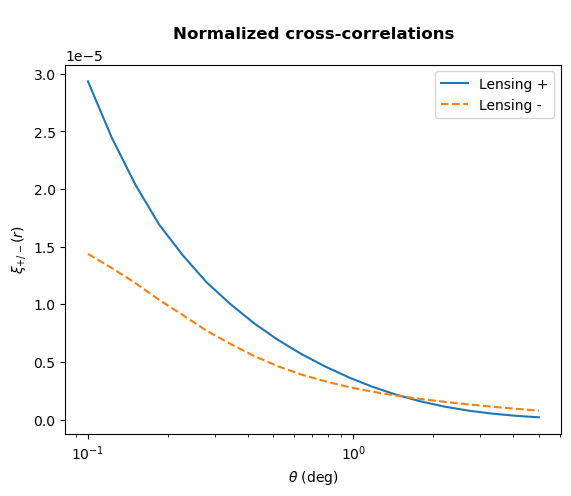

In [ ]:
# Now we calculate the correlation functions, these are the real space equivalent functions of the angular power spectra:

# The angular scales on which we calculate the correlation functions:
theta = np.logspace(-1, np.log10(5.), 20) # in degrees

#Cosmic shear auto correlations:
xi_plus = ccl.correlation(lcdm_cosmo, ell=ells, C_ell=cls_wl, theta=theta, type='GG+', method='FFTLog')
xi_minus = ccl.correlation(lcdm_cosmo, ell=ells, C_ell=cls_wl, theta=theta, type='GG-', method='FFTLog')

#Clustering auto-correlation: 
xi_clu = ccl.correlation(lcdm_cosmo, ell=ells, C_ell=cls_gc, theta=theta, type='NN', method='FFTLog')

# Plot:
plt.figure()
plt.title("\nNormalized cross-correlations\n", weight='bold')

# Plot the correlations:
# NOTE: the normalizations make absolutely no sense, but allow all cross-correlations to be visible in the same plot:
# plt.plot(theta, xi_plus/np.max(xi_plus), label='Normalized lensing +', alpha=0.5)
# plt.plot(theta, xi_minus/np.max(xi_minus), label='Normalized lensing -', alpha=0.5)
# plt.plot(theta, xi_clu/np.max(xi_clu), label='Normalized clustering', alpha=0.5)
plt.plot(theta, xi_plus, label='Lensing +')
plt.plot(theta, xi_minus, '--', label='Lensing -')
# plt.plot(theta, xi_clu, label='Clustering')

# Fancy it up:
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$\xi_{+/-} (r)$')
plt.show()

# Angular cross-correlations
Look at the cross-correlations between angular spectra.

**[CCLX: Angular cross-correlations](https://github.com/LSSTDESC/CCLX/blob/master/Angular%20cross-correlations.ipynb)**

Through the tracers we also obtain information on the radial kernel, the transfer function and potential time derivatives.

In [ ]:
# Let us define the redshift, redshift distribution, bias and intrinsic alignment first. These are needed for the definition of the angular power spectra:
z = np.linspace(0, 1, 256)
nz = np.exp(-0.5*((z-0.5)/0.1)**2) # A Gaussian distribution
b1 = np.ones_like(z)
A_IA = 0.6*np.ones_like(z)

# We define all tracers and put them together in a directory:
tracers = {}

# Galaxy clustering
tracers['g'] = ccl.NumberCountsTracer(lcdm_cosmo, has_rsd=False, dndz=(z, nz), bias=(z, b1))

# Cosmic shear with intrinsic alignments
tracers['s'] = ccl.WeakLensingTracer(lcdm_cosmo, dndz=(z, nz), ia_bias=(z, A_IA))

# CMB lensing
tracers['k'] = ccl.CMBLensingTracer(lcdm_cosmo, z_source=1100)

# The 3 tracers above will be most important to this research, the ones below we consider now as completeness of the example:
# ISW, tSZ & CIB, resp.:
tracers['i'] = ccl.ISWTracer(lcdm_cosmo) # ISW
tracers['y'] = ccl.tSZTracer(lcdm_cosmo, z_max=3.) # tSZ
tracers['c'] = ccl.CIBTracer(lcdm_cosmo, z_min=0.05) # CIB

## Construct 3D power spectra
To find the angular cross-correlations, we must first construct the 3D power spectrum, which we can project into the angular power spectra we would observe from the CMB;
To do this, we use the halo model to construct the power spectra by using the mass function, bias and concentration **([CCLX; Halo model power spectra](https://github.com/LSSTDESC/CCLX/blob/master/Halo-model-Pk.ipynb))**

In [11]:
# We define the range of wavenumber k and the scale factor a for which we want to construct the matter power spectrum:
k = np.log(np.geomspace(1E-4, 100, 256))
a = 1./(1+np.linspace(0, 6., 40)[::-1])

# We then define the ingredients we need from the halo model:
m200def = ccl.halos.MassDef200m
hmf = ccl.halos.MassFuncTinker08(mass_def=m200def)
hbf = ccl.halos.HaloBiasTinker10(mass_def=m200def)
conc = ccl.halos.ConcentrationDuffy08(mass_def=m200def)

hmc = ccl.halos.HMCalculator(mass_function=hmf, halo_bias=hbf, mass_def=m200def)

In [12]:
# This allows us to define the halo profiles, which we do in similar fashion to the tracers above:
profs = {}

# Galaxy clustering, Cosmic shear and CMB lensing, respectively:
profs['g'] = ccl.halos.HaloProfileHOD(mass_def=m200def, concentration=conc) # GC
profs['s'] = ccl.halos.HaloProfileNFW(mass_def=m200def, concentration=conc) # WL
profs['k'] = ccl.halos.HaloProfileNFW(mass_def=m200def, concentration=conc) # CMB L

# ISW, tSZ & CIB:
profs['i'] = ccl.halos.HaloProfileNFW(mass_def=m200def, concentration=conc) # ISW
profs['y'] = ccl.halos.HaloProfilePressureGNFW(mass_def=m200def, x_out=6) # tSZ
profs['c'] = ccl.halos.HaloProfileCIBShang12(mass_def=m200def, concentration=conc, nu_GHz=217) # CIB

# Nowe we make the two point correlators of the profiles;
tracer_list = list(profs.keys())
profs2pt = {f'{t1}-{t2}': ccl.halos.Profile2pt() for t1 in tracer_list for t2 in tracer_list}

# NOTE: the profiles of galaxy clustering and CIB need a custom-made 1-halo 2-point correlator:
profs2pt['g-g'] = ccl.halos.Profile2ptHOD() # This means we are accounting for Poisson correlations in HOD
profs2pt['c-c'] = ccl.halos.Profile2ptCIB()


### Create and project the matter power spectra:

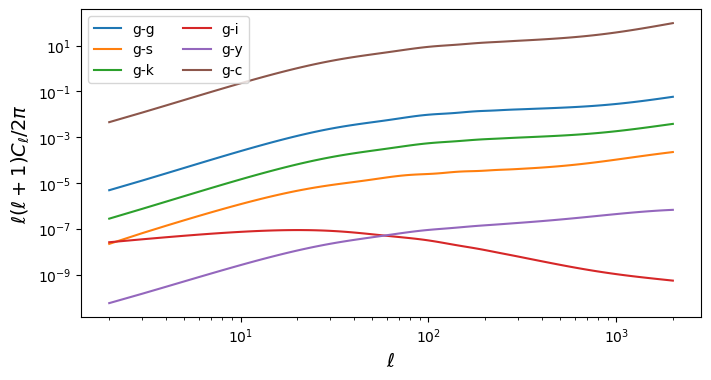

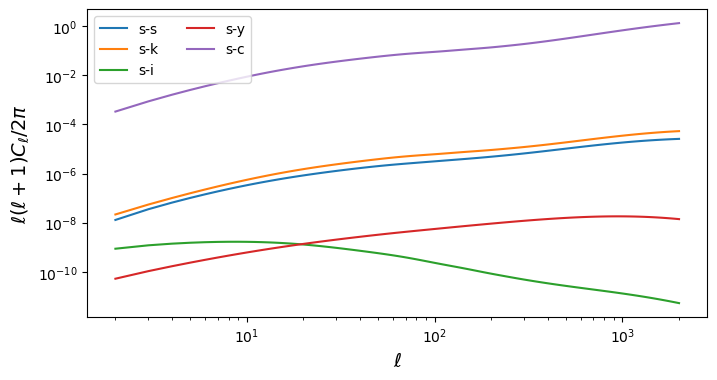

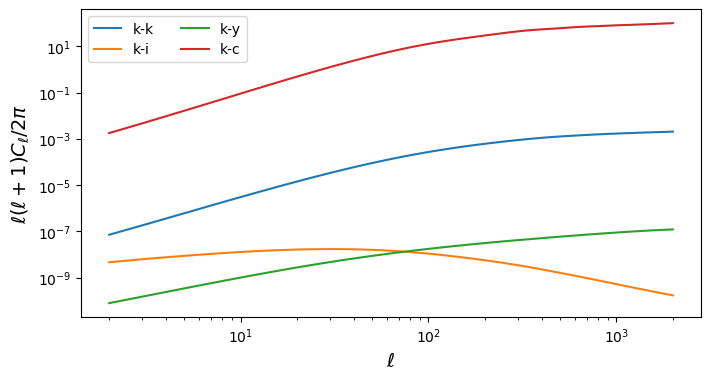

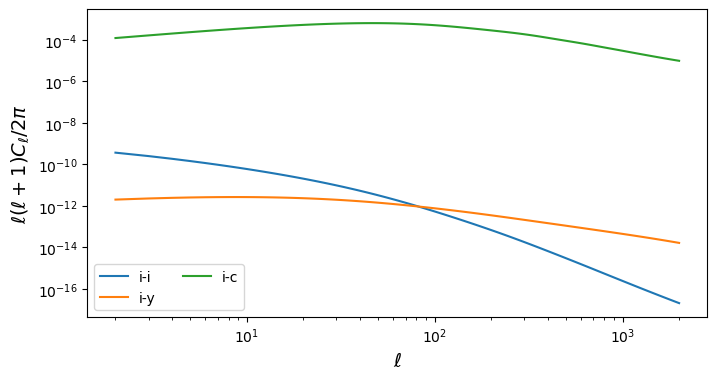

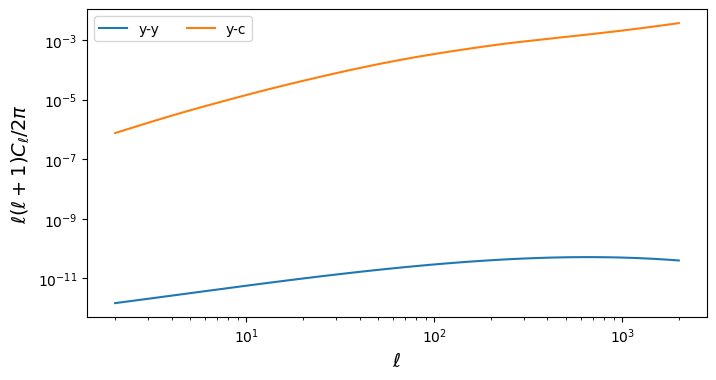

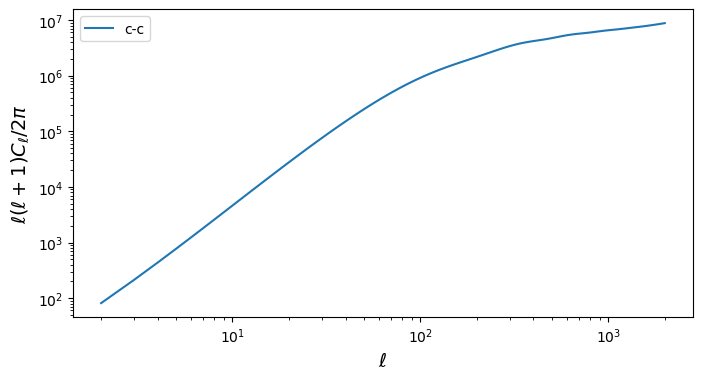

In [ ]:
# Now we can construct the power spectra, using the halo profiles and their correlators defined above:
pks = {f'{t1}-{t2}': ccl.halos.halomod_Pk2D(lcdm_cosmo, hmc,
                                            profs[t1],
                                            prof_2pt=profs2pt[f'{t1}-{t2}'],
                                            prof2=profs[t2],
                                            a_arr=a,
                                            lk_arr=k)
       for t1 in tracer_list for t2 in tracer_list}

# Since we now calculate the angular power spectra, we must define the range of multipole moments we are interested in:
ells = np.unique(np.geomspace(2, 2000, 128).astype(int)).astype(float)

# Which allows us to find the angular auto and cross-correlations, using the tracers and the matter power spectra:
c_ells = {f'{t1}-{t2}': ccl.angular_cl(lcdm_cosmo, tracers[t1], tracers[t2], ells, p_of_k_a=pks[f'{t1}-{t2}'])
          for t1 in tracer_list for t2 in tracer_list}

# Plotting this:
for i1, t1 in enumerate(tracer_list):
    plt.figure(figsize=(8, 4))
    for t2 in tracer_list[i1:]:
        plt.plot(ells, ells*(ells+1)*c_ells[f'{t1}-{t2}']/(2*np.pi), label=f'{t1}-{t2}')
    plt.loglog()
    plt.legend(ncol=2)
    plt.xlabel(r'$\ell$', fontsize=14)
    plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=14)
